# Background

- Started 01-09-2020
    - picked up again 03-24-2020 (COVID-19)
    - and again 04-09-2020 (still COVID-19)
- Direct translation from Matlab Helicalc to Python Helicalc
- Also trying to make conversion pythonic/sensible
- Transfered to GPU machine / picked up again 07-20-2020 (still COVID-19)

# Imports

In [5]:
%load_ext memory_profiler

import numpy as np
import pandas as pd
import math
import scipy.integrate
from scipy.integrate import simps
from scipy.spatial.transform import Rotation
import pickle as pkl
import time

from scipy.constants import mu_0

from matplotlib import pyplot as plt
%matplotlib inline

import torch as tc

### OLD
#import pycuda.autoinit
#import pycuda.driver as cuda
#import pycuda.gpuarray as gpuarray

#import skcuda.integrate

In [6]:
import sys
sys.path.append("/home/ckampa/coding/particle_EM_tracks/emtracks/")
from plotting import config_plots
config_plots()

In [7]:
params_dir = "params/"

In [8]:
mu_0

1.25663706212e-06

In [9]:
4e-7*np.pi

1.2566370614359173e-06

In [10]:
#skcuda.integrate.init()

In [12]:
%memit np.random.randn(1000)

peak memory: 265.90 MiB, increment: 0.00 MiB


# Read Coils

In [ ]:
cols_coil = ["Ri", "Ro", "L", "x", "y", "z" , "rot0", "rot1", "rot2",
             "I_tot", "N_layers", "N_turns", "N_turns_tot", "I_turn", "helicity"]

In [ ]:
cols_coil_rescale = ["Ri", "Ro", "L", "x", "y", "z"]

In [ ]:
Coils = pd.read_csv(params_dir+"r250mm_p10cm_coil.txt", names=cols_coil, delimiter="\t")

In [ ]:
Coils

In [ ]:
for col in cols_coil_rescale:
    Coils[col] = Coils[col] / 1e3

In [ ]:
Coils

## Function

In [ ]:
def read_coils(filename):
    """Read in solenoid coil file.
    
    Args:
        filename (str): Coil file.
    
    Returns:.
        coils (pandas.DataFrame): Each row is a new Coil, columns are parameters of interest.
    """
    # expected columns
    cols_coil = ["Ri", "Ro", "L", "x", "y", "z" , "rot0", "rot1", "rot2",
             "I_tot", "N_layers", "N_turns", "N_turns_tot", "I_turn", "helicity"]
    # columns to rescale
    cols_coil_rescale = ["Ri", "Ro", "L", "x", "y", "z"]
    # read in file to DataFrame
    coils = pd.read_csv(filename, names=cols_coil, delimiter="\t")
    # rescale columns
    for col in cols_coil_rescale:
        coils[col] = coils[col] / 1e3
        
    return coils

# Read Conductors

In [ ]:
cols_cond = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il", "phi0", "phi1"]

In [ ]:
cols_cond_rescale = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il"]

In [ ]:
Conductor = pd.read_csv(params_dir+r"r250mm_p10cm_conductor.txt", names=cols_cond, delimiter="\t")

In [ ]:
Conductor

In [ ]:
for col in cols_cond_rescale:
    Conductor[col] = Conductor[col] / 1e3

In [ ]:
Conductor

## Function

In [ ]:
def read_conductors(filename):
    """Read in solenoid conductor file.
    
    Args:
        filename (str): Conductor file.
    
    Returns:.
        conductors (pandas.DataFrame): Each row is for a new Coil, columns are parameters of interest.
    """
    # expected columns
    cols_cond = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il", "phi0", "phi1"]
    # columns to rescale
    cols_cond_rescale = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il"]
    # read in file to DataFrame
    conductors = pd.read_csv(params_dir+geom_name+"_conductor.txt", names=cols_cond, delimiter="\t")
    # rescale columns
    for col in cols_cond_rescale:
        conductors[col] = conductors[col] / 1e3
    
    return conductors

# Testing Loading Functions

In [ ]:
params_dir = "params/"
geom_name = "r250mm_p10cm"

In [ ]:
coils = read_coils(filename=params_dir+geom_name+"_coil.txt")

In [ ]:
coils

In [ ]:
conductors = read_conductors(filename=params_dir+geom_name+"_conductor.txt")

In [ ]:
conductors

# Main Function / Driving Script

In [ ]:
mu_0

In [ ]:
# should i return a df??
# i think no for not overloading memory
# and will want to write to file every calculation anyway

# do return bus later

def helicalc_main(outfile, coilfile, conductorfile, xs, ys, zs):
    """Run 'helicalc' calculation. Calculates magnetic field from system of solenoids on a 3d grid of positions.
    
    Args:
        outfile (str): Output file.
        coilfile (str): Coil file.
        conductorfile (str): Conductor file.
        xs (numpy.array): Grid x locations.
        ys (numpy.array): Grid y locations.
        zs (numpy.array): Grid z locations.
    """
    # read parameters
    coils = read_coils(filename=coilfile)
    conductors = read_conductors(filename=conductorfile)
    geom = pd.concat([coils, conductors], axis=1)
    # EXTRA GEOM CALCULATIONS
    # MAYBE ADD IN A DIFFERENT FUNCTION?
    # yaw
    geom.loc[:, 'Yaw'] = geom.rot1
    geom.loc[:, 'Yaw_rad'] = geom.Yaw * np.pi / 180.
    # pitch
    geom.loc[:,'h'] = geom.L/ geom.N_turns
    
    # integration limits for rectangular conductor
    # of dimensions (zeta1-zeta0) x (rho1-rho0)
    # zeta
    geom.loc[:,'zeta0'] = (geom.w_cable - geom.w_sc)/2. + geom.t_ci
    geom.loc[:,'zeta1'] = geom.zeta0 + geom.w_sc
    # rho limits for first layer
    # and higher layers increased by offsets
    geom.loc[:,'rho0_a'] = geom.Ri + (geom.h_cable - geom.h_sc)/2 + geom.t_gi + geom.t_ci
    geom.loc[:,'rho1_a'] = geom.rho0_a + geom.h_sc
    
    # current density
    geom.loc[:,'j'] = geom.I_turn / ((geom.rho1_a - geom.rho0_a)*(geom.zeta1 - geom.zeta0))
    
    # mu factor (constant) in Biot-Savart integration
    geom.loc[:,'mu'] = mu_0 * geom.j / (4*np.pi)
    ###
    '''
    # set up grid
    XX, YY, ZZ = np.meshgrid(xs, ys, zs, indexing="ij")
    grid = pd.DataFrame({"X":XX.ravel(), "Y":YY.ravel(), "Z":ZZ.ravel()})
    '''
    # start file
    nx, ny, nz = (len(xs), len(ys), len(zs))
    with open(outfile, "w") as file:
        file.write("Helicalc field map (GPU)\n")
        file.write(f"Helix Parameters (coil, conductor): {coilfile}, {conductorfile}\n")
        file.write(f"{nx}, {ny}, {nz} (x, y, z) grid\n")
        file.write(f"({nx*ny*nz} field points)\n")
        file.write("x[mm]\ty[mm]\tz[mm]\tBx[T]\tBy[T]\tBz[T]\n")
    print("File Creation Successful:\n")
    print("---------------------------------------------------------\n\n")
    # start timer
    t0 = time.time()
    last_x = np.nan # do something cleaner next time
    last_y = ys[0]
    Bxsum = []
    Bysum = []
    Bzsum = []        
    # start loops!
    '''
    n = 0
    for pos in grid.itertuples():
        if not np.isclose(pos.Y, last_y):
            print(pos.Y, last_y)
            print(len(zs), len(Bxsum))
            #print(f"    y: {pos.Y}")
            ## WRITE TO FILE
            with open(outfile, "a") as file:
                for i, z in enumerate(zs):
                    file.write("\t".join([str(1e3*last_x), str(1e3*last_y), str(1e3*z),\
                                          str(Bxsum[i]), str(Bysum[i]), str(Bzsum[i])]) + "\n")
            
            Bxsum = []
            Bysum = []
            Bzsum = []
            last_y = pos.Y
            
        
        if not np.isclose(pos.X, last_x):
            last_x = pos.X
            print(f"Processing x: {pos.X}; Elapsed Time: {time.time()-t0}; {n/len(grid) * 100}% Complete")
            
        # CALCULATE FIELD
        Bx, By, Bz = field_helix_gpu(coils, conductors, pos)
        print(Bx, By, Bz)
        Bxsum.append(Bx)
        Bysum.append(By)
        Bzsum.append(Bz)
        
        n += 1
    '''
    
    n = 0
    tot_N = len(xs)*len(ys)*len(zs)
    #N = len(zs)
    #z_N = zs
    for x in xs:
        print(f"Processing x: {1e3*x}; Elapsed Time: {time.time()-t0}; {n/tot_N * 100}% Complete")
        #x_N = x * np.ones(N)
        for y in ys:
            #y_N = y * np.ones(N)
            
            Bxsum = []
            Bysum = []
            Bzsum = []
            for z in zs:
                Bx_ = 0.
                By_ = 0.
                Bz_ = 0.
                for g in geom.itertuples():
                    Bx, By, Bz = field_helix_gpu(g, x, y, z)
                    Bx_ += Bx
                    By_ += By
                    Bz_ += Bz
                Bxsum.append(Bx_)
                Bysum.append(By_)
                Bzsum.append(Bz_)
            
            
            '''
            Bxsum, Bysum, Bzsum = np.zeros((3, N))
            
            for coil,conductor in zip(coils.itertuples(), conductors.itertuples()):
                Bx, By, Bz = field_helix_gpu(geom, x_N, y_N, z_N)
                Bxsum += Bx
                Bysum += By
                Bzsum += Bz
            '''
            
            ## WRITE TO FILE
            with open(outfile, "a") as file:
                for i, z in enumerate(zs):
                    file.write("\t".join([str(1e3*last_x), str(1e3*last_y), str(1e3*z),\
                                          str(Bxsum[i]), str(Bysum[i]), str(Bzsum[i])]) + "\n")
            n += N
    
    tot_time = time.time() - t0
    print(f"Calculation Complete! Elapsed Time: {tot_time}; {n/tot_N * 100}% Complete")
    print(f"Time / Point: {tot_time / tot_N} s / point")

In [ ]:
def field_helix_gpu(g, x, y, z):
    # g == geom named tuple (pandas)
    
    
    
    
    
    
    return 1., 2., 3.

In [ ]:
for coil in coils.itertuples():
    c = coil

In [ ]:
for conductor in conductors.itertuples():
    cd = conductor

In [ ]:
c

In [ ]:
cd

In [ ]:
type(c)

In [ ]:
c

In [ ]:
coils

In [ ]:
conductors

In [ ]:
g = pd.concat([coils, conductors], axis=1)

In [ ]:
g

In [ ]:
coils.columns

In [ ]:
conductors.columns

In [ ]:
np.zeros((3, 10))

In [ ]:
coils.loc[0, 'Ri']

In [ ]:
coils.loc[0].Ri

In [ ]:
start_time = time.time()

In [ ]:
end_time = time.time()

In [ ]:
end_time-start_time

In [ ]:
out_dir = "maps/"
params_dir = "params/"
geom_name = "r250mm_p10cm"
out_name = "r250mm_p10cm_03-24-2020.txt"

In [ ]:
outfile = out_dir+out_name
coilfile = params_dir+geom_name+"_coil.txt"
conductorfile = params_dir+geom_name+"_conductor.txt"

In [ ]:
xs = [-50, 0, 50]
ys = [-50, 0, 50]
zs = np.linspace(-4, 4, 9)

In [ ]:
helicalc_main(outfile=out_dir+out_name, coilfile=params_dir+geom_name+"_coil.txt", 
              conductorfile=params_dir+geom_name+"_conductor.txt",
              xs=xs, ys=ys, zs=zs)

In [ ]:
xs

In [ ]:
coils = read_coils(filename=coilfile)
conductors = read_conductors(filename=conductorfile)
# set up grid
XX, YY, ZZ = np.meshgrid(xs, ys, zs, indexing="ij")
grid = pd.DataFrame({"X":XX.ravel(), "Y":YY.ravel(), "Z":ZZ.ravel()})
# start file
nx, ny, nz = (len(xs), len(ys), len(zs))

In [ ]:
grid

In [ ]:
last_x = np.nan
last_y = np.nan
#last_z = zs[0]

In [ ]:
for pos in grid.itertuples():
    if pos.X != last_x:
        last_x = pos.X
        print(f"x: {pos.X}")
    if pos.Y != last_y:
        last_y = pos.Y
        print(f"    y: {pos.Y}")

## Combined Coils and Conductor

In [ ]:
def read_solenoid_geom(geom_name):
    # coils
    cols_coil = ["Ri", "Ro", "L", "x", "y", "z" , "rot0", "rot1", "rot2",
                 "I_tot", "N_layers", "N_turns", "N_turns_tot", "I_turn", "helicity"]
    cols_coil_rescale = ["Ri", "Ro", "L", "x", "y", "z"]

    Coils = pd.read_csv(params_dir+geom_name+"_coil.txt", names=cols_coil, delimiter="\t")
    for col in cols_coil_rescale:
        Coils[col] = Coils[col] / 1e3
    # conductor
    cols_cond = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il", "phi0", "phi1"]
    cols_cond_rescale = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il"]

    Conductor = pd.read_csv(params_dir+geom_name+"_conductor.txt", names=cols_cond, delimiter="\t")
    for col in cols_cond_rescale:
        Conductor[col] = Conductor[col] / 1e3
    
    return Coils, Conductor

In [ ]:
geom_name = "r250mm_p10cm"

In [ ]:
Coils, Conductor = read_solenoid_geom(geom_name)

In [ ]:
Coils

In [ ]:
Conductor

In [ ]:
%timeit Coils, Conductor = read_solenoid_geom(geom_name)

This only happens once in the program execution, so this is fine to stay serialized on CPU.

## "helicalc_bfield_gpu"

- ignoring return bus issue until later

In [ ]:
# get coils and conductors
Coils, Conductor = read_solenoid_geom(geom_name)

In [ ]:
# number of coils read
len(Coils)

In [ ]:
nx, ny, nz = [3,3,3]

In [ ]:
nx

In [ ]:
x0, y0, z0 = [-.25, -.25,-.25]

In [ ]:
x0

In [ ]:
dx, dy, dz = [0.25, 0.25, 0.25]

In [ ]:
dx

In [ ]:
xf = x0 + (nx-1)*dx
yf = y0 + (ny-1)*dy
zf = z0 + (nz-1)*dz

In [ ]:
xf, yf, zf

In [ ]:
xs = np.linspace(x0, xf, nx)
ys = np.linspace(y0, yf, ny)
zs = np.linspace(z0, zf, nz)

In [ ]:
xs, ys, zs

## Trapezoidal (CPU)

In [ ]:
## trapezoidal integration CPU

In [14]:
#%%file ../helicalc/integrate.py
def trapz_3d(xs, ys, zs, integrand_xyz, int_func=tc.trapz):
    return int_func(int_func(int_func(integrand_xyz, axis=-1, x=zs), axis=-1, x=ys), axis=-1, x=xs)

- Start with some 3d integral with a known, analytical result. (https://tutorial.math.lamar.edu/Solutions/CalcIII/TripleIntegrals/Prob1.aspx)
- Let's also try using both np.trapz as well as scipy.integrate.simps and compare results / speeds.

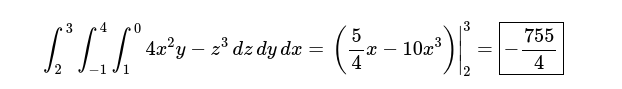

In [15]:
result_true = -755/4

In [16]:
dxyz = 0.1
dxyz_fine = 0.01

In [17]:
np.linspace(2, 3, int((3-2)/0.1 + 1))

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [18]:
def f_ex01(x, y, z):
    return 4*x**2*y - z**3

In [19]:
def integral_tester(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz):
    xs = np.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1)))
    ys = np.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1)))
    zs = np.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1)))
    X, Y, Z = np.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    result = trapz_3d(xs, ys, zs, integrand_xyz, int_func)
    return result

In [20]:
integral_tester(), integral_tester(int_func=simps)

(-188.78046875, -188.74999999999997)

In [21]:
integral_tester(dxyz=3*[1e-2])-result_true, integral_tester(dxyz=3*[1e-2],int_func=simps)-result_true

(-0.00036984589752364627, 2.842170943040401e-14)

In [22]:
integral_tester(dxyz=3*[5e-1],int_func=simps)-result_true,\
integral_tester(dxyz=3*[1e-1],int_func=simps)-result_true,\
#integral_tester(dxyz=3*[1e-3],int_func=simps)-result_true

(188.75, 2.842170943040401e-14)

In [23]:
integral_tester(dxyz=3*[1e-1])-result_true,\
integral_tester(dxyz=3*[1e-2])-result_true,\
#integral_tester(dxyz=3*[1e-3],int_func=simps)-result_true

(-0.03046875000001137, -0.00036984589752364627)

# Trapezoidal (GPU)

In [ ]:
def integral_tester0(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz, lib=np, dev='cuda:0'):
    xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1)))
    ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1)))
    zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1)))
    if lib is tc:
        X, Y, Z = lib.meshgrid(xs,ys,zs)
    else:
        X, Y, Z = lib.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    result = trapz_3d(xs, ys, zs, integrand_xyz, int_func)
    return result

def integral_tester1(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz, lib=np, dev='cuda:0'):
    xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
    ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
    zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
    if lib is tc:
        #xs = xs.to(tc.device(dev))
        #ys = ys.to(tc.device(dev))
        #zs = zs.to(tc.device(dev))
        X, Y, Z = lib.meshgrid(xs,ys,zs)
    else:
        X, Y, Z = lib.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    result = trapz_3d(xs, ys, zs, integrand_xyz, int_func)
    return result


def integral_tester2(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz, lib=np, dev='cuda:0'):
    xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1)))
    ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1)))
    zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1)))
    if lib is tc:
        X, Y, Z = lib.meshgrid(xs,ys,zs)
        X = X.to(tc.device(dev))
        Y = Y.to(tc.device(dev))
        Z = Z.to(tc.device(dev))
    else:
        X, Y, Z = lib.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    result = trapz_3d(xs.cuda(), ys.cuda(), zs.cuda(), integrand_xyz, int_func)
    return result


def integral_tester3(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz, lib=np, dev='cuda:0'):
    xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1)))
    ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1)))
    zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1)))
    if lib is tc:
        X, Y, Z = lib.meshgrid(xs,ys,zs)
    else:
        X, Y, Z = lib.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    if lib is tc:
        integrand_xyz = integrand_xyz.to(tc.device(dev))
    result = trapz_3d(xs.cuda(), ys.cuda(), zs.cuda(), integrand_xyz, int_func)
    return result

In [ ]:
%time integral_tester0(dxyz=3*[5e-3],int_func=simps, lib=np)

In [ ]:
%time integral_tester0(dxyz=3*[5e-3],int_func=np.trapz, lib=np)

In [ ]:
%time integral_tester0(dxyz=3*[5e-3],int_func=tc.trapz, lib=tc)

In [ ]:
%time integral_tester1(dxyz=3*[5e-3],int_func=tc.trapz, lib=tc) # .to()

In [ ]:
%time integral_tester1(dxyz=3*[5e-3],int_func=tc.trapz, lib=tc) # .cuda()

In [ ]:
integral_tester1(dxyz=3*[2e-3],int_func=tc.trapz, lib=tc) # .cuda()

In [ ]:
a = [2,3]
#a = [-1,4]
#a = [1,0]

In [ ]:
np.linspace(a[0],a[1], abs(a[1]-a[0]))

In [ ]:
%time integral_tester2(dxyz=3*[5e-3],int_func=tc.trapz, lib=tc)

In [ ]:
%time integral_tester3(dxyz=3*[5e-3],int_func=tc.trapz, lib=tc)

In [ ]:
235/6.09 # 227

In [ ]:
tc.cuda.set_device(0)

In [ ]:
xs = tc.linspace(0,10,10)

In [ ]:
xs.device

In [ ]:
xs.to(tc.device('cuda:0'))

In [ ]:
xs.device

In [ ]:
xs = tc.linspace(0,10,10).cuda()
ys = tc.linspace(0,10,10).cuda()
zs = tc.linspace(0,10,10).cuda()

In [ ]:
xs.device

In [ ]:
X, Y, Z = tc.meshgrid(xs,ys,zs)

In [ ]:
X.device

# Class Based Setup (cached xs, ys, zs)

In [ ]:
def integral_tester1(dxyz=[0.1,0.1,0.1], xyz_lims =[[2,3],[-1,4],[1,0]], integrand_func=f_ex01, int_func=np.trapz, lib=np, dev='cuda:0'):
    xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
    ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
    zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
    if lib is tc:
        #xs = xs.to(tc.device(dev))
        #ys = ys.to(tc.device(dev))
        #zs = zs.to(tc.device(dev))
        X, Y, Z = lib.meshgrid(xs,ys,zs)
    else:
        X, Y, Z = lib.meshgrid(xs,ys,zs, indexing='ij')
    integrand_xyz = integrand_func(X,Y,Z)
    result = trapz_3d(xs, ys, zs, integrand_xyz, int_func)
    return result

In [ ]:
def f_ex01(x, y, z, x0, y0, z0):
    return 4*(x-x0)**2*(y-y0) - (z-z0)**3

In [ ]:
class Integrator(object):
    def __init__(self, dxyz, xyz_lims, int_func=tc.trapz, lib=tc, dev='cuda:0'):
        self.xs = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
        self.ys = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
        self.zs = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
        self.X, self.Y, self.Z = lib.meshgrid(self.xs,self.ys,self.zs)
        #self.integrand_func = get_int_func(X,Y,Z, int_func)
    
    def integrate(self, int_func, x0=0, y0=0, z0=0):
        # int_func must have params (x, y, z, x0, y0, z0)
        integrand_xyz = int_func(self.X,self.Y,self.Z,x0,y0,z0)
        self.last_result = trapz_3d(self.xs, self.ys, self.zs, integrand_xyz, tc.trapz)

        return self.last_result

In [ ]:
%time MyIntegrator = Integrator(dxyz=3*[2e-3], xyz_lims=[[2,3],[-1,4],[1,0]])

In [ ]:
%time MyIntegrator.integrate(f_ex01)

In [ ]:
# LONG RUN
#%timeit MyIntegrator.integrate(f_ex01)

In [ ]:
del(MyIntegrator)

In [ ]:
tc.cuda.empty_cache()

# Helix function

In [ ]:
Coils, Conductor = read_solenoid_geom(geom_name)

In [ ]:
Coils.iloc[0].values

In [ ]:
Coils.iloc[0].Ri

In [ ]:
Coils.iloc[0]

In [ ]:
Conductor.iloc[0]

In [2]:
#%%file ../helicalc/geometry.py
def read_solenoid_geom_combined(geom_name, sep=',', skiprows=1):
    # coils
    cols_coil = ["Coil_Num","Ri", "Ro", "L", "x", "y", "z" , "rot0", "rot1", "rot2",
                 "I_tot", "N_layers", "N_turns", "N_turns_tot", "I_turn", "helicity"]
    cols_coil_rescale = ["Ri", "Ro", "L", "x", "y", "z"]

    Coils = pd.read_csv(params_dir+geom_name+"_coil.txt", names=cols_coil, sep=sep, skiprows=skiprows)
    for col in cols_coil_rescale:
        Coils[col] = Coils[col] / 1e3
    # conductor
    cols_cond = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il", "phi0", "phi1"]
    cols_cond_rescale = ["h_cable", "w_cable", "h_sc", "w_sc", "t_gi", "t_ci", "t_il"]

    Conductor = pd.read_csv(params_dir+geom_name+"_conductor.txt", names=cols_cond, sep=sep, skiprows=skiprows)
    for col in cols_cond_rescale:
        Conductor[col] = Conductor[col] / 1e3
    
    # integration limits zeta
    Conductor['zeta0'] = (Conductor.w_cable-Conductor.w_sc)/2. + Conductor.t_ci
    Conductor['zeta1'] = Conductor.zeta0 + Conductor.w_sc
    
    df = pd.concat([Coils, Conductor], axis=1)
    
    # integration limits rho for first layer
    # higher layers increased by offsets
    df['rho0_a'] = df.Ri + (df.h_cable - df.h_sc)/2. + df.t_gi + df.t_ci
    df['rho1_a'] = df.rho0_a + df.h_sc
    
    # current density
    df['j'] = df.I_turn / ((df.rho1_a-df.rho0_a)*(df.zeta1-df.zeta0))
    #df['j'] = df.I_turn / (df.w_sc*df.h_sc) # faster/more clear?
    
    df['mu_fac'] = mu_0 * df.j / (4*np.pi)
    
    df['phi_i'] = 0.
    df['phi_f'] = 2*np.pi*df.N_turns
    #df['pitch'] = df.w_cable + 2.*df.t_ci # BAD
    df['pitch'] = df.L / df.N_turns
    
    #return Coils, Conductor
    return df

In [3]:
geom_name = 'DS_V13' # + '_adjusted'
#geom_name = 'r1m_p10cm'

In [4]:
geom_df = read_solenoid_geom_combined(geom_name)

NameError: name 'pd' is not defined

In [ ]:
geom_df

In [ ]:
geom_name

In [ ]:
%timeit geom_df = read_solenoid_geom_combined(geom_name)

In [ ]:
geom_df = read_solenoid_geom_combined(geom_name, delimiter="\t")

In [ ]:
geom_df

In [ ]:
geom_df.phi0,geom_df.phi1

In [ ]:
geom_df.t_ci, geom_df.t_gi

In [ ]:
geom_df.pitch, geom_df.w_cable

In [ ]:
geom_df.iloc[0].I_turn, geom_df.iloc[0].j

In [ ]:
geom_df.N_turns

In [ ]:
geom_df.helicity

In [ ]:
geom_df.L

In [ ]:
geom_df.iloc[0]

In [ ]:
def rx(rho, phi, x):
    return x - rho*np.cos(phi)
def ry(rho, phi, hel, y):
    return y - hel*rho*np.sin(phi)
def rz(zeta, phi, pitch, L, z):
    return z - (zeta + phi * pitch/(2*np.pi) - L/2) 

In [ ]:
def r2(x, y, z, rho, zeta, phi, hel, pitch, L):
    return (rx(rho, phi, x)**2 + ry(rho, phi, hel, y)**2 + rz(zeta, phi, pitch, L, z)**2)

In [ ]:
%time r2(0, 0, 0, *geom_df[['rho0_a', 'zeta0', 'phi_i', 'helicity', 'pitch', 'L']].iloc[0])

In [ ]:
r2(0, 0, 0, *geom_df[['rho0_a', 'zeta0', 'phi_i', 'helicity', 'pitch', 'L']].iloc[0])**(1/2)

In [ ]:
(9.2 / 2)**2 + geom_df.Ri.iloc[0]**2

In [ ]:
((9.2 / 2)**2 + geom_df.Ri.iloc[0]**2)**(1/2)

In [25]:
#%%file ../helicalc/coil.py
def rx(rho, COSPHI, x):
    return x - rho*COSPHI
def ry(rho, SINPHI, hel, y):
    return y - hel*rho*SINPHI
def rz(zeta, phi, pitch, L, z):
    return z - (zeta + phi * pitch/(2*np.pi) - L/2) 

In [27]:
#%%writefile -a ../helicalc/coil.py
#
def helix_integrand_Bx(RX, RY, RZ, R2_32, rho, COSPHI, SINPHI, hel, pitch, L):
    return (rho * COSPHI * RZ - hel * pitch/(2*np.pi) * RY) / R2_32
def helix_integrand_By(RX, RY, RZ, R2_32, rho, COSPHI, SINPHI, hel, pitch, L):
    return (hel * rho * SINPHI * RZ + hel* pitch/(2*np.pi) *RX) / R2_32
def helix_integrand_Bz(RX, RY, RZ, R2_32, rho, COSPHI, SINPHI, hel, pitch, L):
    return (-hel * rho * SINPHI * RY - rho * COSPHI * RX) / R2_32

In [ ]:
# coarse steps (quick)
'''
rh_step = (geom_df.rho1_a-geom_df.rho0_a).iloc[0]/3
z_step = (geom_df.zeta1-geom_df.zeta0).iloc[0]/3
phi_step = (geom_df.phi_f-geom_df.phi_i).iloc[0]/46000# 4600 # 46000
'''
# fine steps (slower)
rh_step = (geom_df.rho1_a-geom_df.rho0_a).iloc[0]/7
z_step = (geom_df.zeta1-geom_df.zeta0).iloc[0]/3
phi_step = (geom_df.phi_f-geom_df.phi_i).iloc[0]/1000000# 4600 # 46000

In [ ]:
dxyz = [rh_step, z_step, phi_step]

In [ ]:
dxyz

In [ ]:
rh_step, z_step, phi_step

- Now just set up integrator object! (Hopefully quick with caching.)

In [29]:
#%%writefile -a ../helicalc/coil.py
#
class CoilIntegrator(object):
    def __init__(self, geom_coil, dxyz, int_func=tc.trapz, lib=tc, dev=0):
        # x, y, z --> rho, zeta, phi
        tc.cuda.set_device(dev)
        rho_lims = [geom_coil.rho0_a, geom_coil.rho1_a]
        zeta_lims = [geom_coil.zeta0, geom_coil.zeta1]
        phi_lims = [geom_coil.phi_i, geom_coil.phi_f]
        xyz_lims = [rho_lims, zeta_lims, phi_lims]
        self.rhos = lib.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
        self.zetas = lib.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
        self.phis = lib.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
        self.RHO, self.ZETA, self.PHI = lib.meshgrid(self.rhos,self.zetas,self.phis)
        self.SINPHI = lib.sin(self.PHI)
        self.COSPHI = lib.cos(self.PHI)
        self.geom_coil = geom_coil
        self.int_func = int_func
        self.lib = lib
        self.dev = dev
        self.XYZ_rot = geom_coil[[f'rot{i:d}' for i in [0,1,2]]].values
        self.XYZ_rot_rad = np.radians(self.XYZ_rot)
        self.mu2e_to_coil = Rotation.from_euler('XYZ', -self.XYZ_rot_rad)
        self.coil_to_mu2e = self.mu2e_to_coil.inv()
        self.xc, self.yc, self.zc = geom_coil[['x','y','z']].values
        lr = len(self.rhos)
        lz = len(self.zetas)
        lp = len(self.phis)
        self.est_mem_init_mb = (2*(lr + lz + lp) + 2*(lr*lz*lp))*1e-5
        self.est_mem_run_mb = (2*(lr + lz + lp) + 7*(lr*lz*lp))*1e-5
    
    def integrate(self, x0=0, y0=0, z0=0):
        # rotate based on geom
        #x0, y0, z0 = transform_field_point(x0,y0,z0)
        # rotate/translate
        x0, y0, z0 = self.mu2e_to_coil.apply(np.array([x0-self.xc, y0-self.yc, z0-self.zc]))
        # calculate repeated calculations
        RX = rx(self.RHO, self.COSPHI, x0)
        RY = ry(self.RHO, self.SINPHI, self.geom_coil.helicity, y0)
        RZ = rz(self.ZETA, self.PHI, self.geom_coil.pitch, self.geom_coil.L, z0)
        R2_32 = (RX**2+RY**2+RZ**2)**(3/2)
        result = []
        # int_func must have params (x, y, z, x0, y0, z0)
        for integrand_func in [helix_integrand_Bx, helix_integrand_By, helix_integrand_Bz]:
            integrand_xyz = self.geom_coil.mu_fac * integrand_func(RX, RY, RZ, R2_32, self.RHO, self.COSPHI,
                                                                   self.SINPHI, self.geom_coil.helicity,
                                                                   self.geom_coil.pitch, self.geom_coil.L)
            result.append(trapz_3d(self.rhos, self.zetas, self.phis, integrand_xyz, self.int_func).item())
        B_vec = np.array(result)
        # rotate vector back to mu2e coordinates
        B_vec_rot = self.coil_to_mu2e.apply(B_vec)
        self.last_result = B_vec_rot
        return self.last_result, B_vec

In [ ]:
3*285*(2*np.pi*850) / 1e3 / 5e-2 # m (in phi), PS Coil #1

In [ ]:
43*8*(2*np.pi*465) / 1e3 / 5e-2 # m (in phi), TS3 Coil #28

In [ ]:
1*244*(2*np.pi*1050) / 1e3  / 5e-2# m (in phi), DS Coil #63-65

In [ ]:
phi_step * 1050

In [ ]:
rh_step*1e3, z_step*1e3

In [ ]:
(geom_df.rho1_a-geom_df.rho0_a)

In [30]:
rh_step

NameError: name 'rh_step' is not defined

In [ ]:
geom_name

In [ ]:
geom_name = 'DS_V13_adjusted'
#geom_name = 'DS_V13'
#geom_name = 'r1m_p10cm'

In [ ]:
geom_df = read_solenoid_geom_combined(geom_name)

In [ ]:
geom_df

In [ ]:
geom_df.N_turns

In [ ]:
#for col in geom_df.columns:
#    print(col, geom_df[col].iloc[0])

In [ ]:
MyCoilIntegrator = CoilIntegrator(geom_df.iloc[0], dxyz)

In [ ]:
MyCoilIntegrator.integrate()

In [ ]:
%time MyCoilIntegrator.integrate(0.,0.,.025)

In [ ]:
Bx, By, Bz = MyCoilIntegrator.integrate(0.,0.,.025)

In [ ]:
%time Bx.item(), By.item(), Bz.item()

In [ ]:
del(MyCoilIntegrator)
tc.cuda.empty_cache()

# Rotations

In [ ]:
pos_c = np.array([0., 0., 0.]) # some TS centered in x
pos = np.array([-3896., 0, 8.0]) # around the start of the tracker field point

In [ ]:
#XYZ_rot = geom_df[[f'rot{i:d}' for i in [0,1,2]]].values
XYZ_rot = np.array([0, -90.0, 0])
XYZ_rot_rad = np.radians(XYZ_rot)

In [ ]:
XYZ_rot, XYZ_rot_rad

In [ ]:
# rot 0, 1, 2 = pitch, yaw, roll (== rotation about x axis, y axis, z axis)

In [ ]:
# capital letters for intrinsic rotation, lowercase for extrinsic rotation

In [ ]:
rot_func = Rotation.from_euler('XYZ', -XYZ_rot_rad)

In [ ]:
inv_rot_func = rot_func.inv()

In [ ]:
inv_rot_func.apply(pos-pos_c)

In [ ]:
rot_func.apply(pos-pos_c)

- So looks like we should use inverse rotation function to find field point in solenoid's coordinates.
    - Or (-1*angles) for rotating into coil frame, (1*angles) for rotating back to mu2e frame
- Now suppose we get a Bfield vector in the rotated frame, we must rotate back to original frame, and this is our answer!

In [ ]:
B_vec = np.array([0, 0, 1])

In [ ]:
B_vec_mu2e = inv_rot_func.apply(B_vec)

In [ ]:
B_vec_mu2e

# Memory Usage

- From https://discuss.pytorch.org/t/access-gpu-memory-usage-in-pytorch/3192/4

In [ ]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [ ]:
get_gpu_memory_map()

In [ ]:
get_gpu_memory_map()[1]

In [ ]:
import torch as tc

In [ ]:
import tracemalloc

In [ ]:
tracemalloc.start()

In [ ]:
dev = 0

In [ ]:
tc.cuda.set_device(dev)

In [ ]:
for obj in ['rhos', 'zetas', 'phis', 'RHO', 'ZETA', 'PHI', 'SINPHI', 'COSPHI', 'container']:
    try:
        exec(f'del({obj})')
    except:
        pass

In [ ]:
tc.cuda.empty_cache()

In [ ]:
mems = [get_gpu_memory_map()[dev]]

In [ ]:
gd = geom_df.iloc[0]
rho_lims = [gd.rho0_a, gd.rho1_a]
zeta_lims = [gd.zeta0, gd.zeta1]
phi_lims = [gd.phi_i, gd.phi_f]
xyz_lims = [rho_lims, zeta_lims, phi_lims]
rhos = tc.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
mems.append(get_gpu_memory_map()[dev])
zetas = tc.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
mems.append(get_gpu_memory_map()[dev])
phis = tc.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
mems.append(get_gpu_memory_map()[dev])
RHO, ZETA, PHI = tc.meshgrid(rhos,zetas,phis)
mems.append(get_gpu_memory_map()[dev])
SINPHI = tc.sin(PHI)
mems.append(get_gpu_memory_map()[dev])
COSPHI = tc.cos(PHI)
mems.append(get_gpu_memory_map()[dev])

In [ ]:
mems

In [ ]:
mem_per = 0.001 # mb / item

In [ ]:
(len(rhos) + len(zetas) + len(phis) + (3 + 2 + 4 + 1)*len(rhos)*len(zetas)*len(phis)) * mem_per / 1000 # GB memory

In [ ]:
sys.getsizeof(SINPHI.storage()) * 1e-6

In [ ]:
128 * 10

In [ ]:
sys.getsizeof(rhos.storage()) * 1e-6, \
sys.getsizeof(zetas.storage()) * 1e-6, \
sys.getsizeof(phis.storage()) * 1e-6

In [ ]:
sys.getsizeof(rhos.storage()) * 1e-6 / len(rhos),\
sys.getsizeof(zetas.storage()) * 1e-6 / len(zetas),\
sys.getsizeof(phis.storage()) * 1e-6 / len(phis)

In [ ]:
container = [rhos, zetas, phis, RHO, ZETA, PHI, SINPHI, COSPHI]

In [ ]:
total_st = np.array([sys.getsizeof(i.storage())*1e-6 for i in container])

In [ ]:
total_st

In [ ]:
np.sum(total_st) * 1e-2

In [ ]:
total_st_per = np.array([sys.getsizeof(i.storage())/i.numel() * 1e-6 for i in container])

In [ ]:
total_st_per

In [ ]:
RHO.numel()

In [ ]:
mem_per = 1e-5

In [ ]:
(len(rhos) + len(zetas) + len(phis) + (3 + 2 + 4 + 1)*len(rhos)*len(zetas)*len(phis)) * mem_per / 1000 # GB memory

In [ ]:
snapshot = tracemalloc.take_snapshot()

In [ ]:
top_stats = snapshot.statistics('lineno')

In [ ]:
for ts in top_stats[:10]:
    print(ts)

In [ ]:
1019-731, 1153-1019

In [ ]:
get_gpu_memory_map()[1]

# Memory Profiler

In [ ]:
def gpu_load(geom_coil, dxyz , dev=0):
    # set device
    tc.cuda.set_device(dev)
    # x, y, z --> rho, zeta, phi
    rho_lims = [geom_coil.rho0_a, geom_coil.rho1_a]
    zeta_lims = [geom_coil.zeta0, geom_coil.zeta1]
    phi_lims = [geom_coil.phi_i, geom_coil.phi_f]
    xyz_lims = [rho_lims, zeta_lims, phi_lims]
    rhos = tc.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
    zetas = tc.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
    phis = tc.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
    RHO, ZETA, PHI = tc.meshgrid(rhos,zetas,phis)
    SINPHI = tc.sin(PHI)
    COSPHI = tc.cos(PHI)
    #geom_coil = geom_coil
    #int_func = int_func
    #lib = lib
    #dev = dev
    XYZ_rot = geom_coil[[f'rot{i:d}' for i in [0,1,2]]].values
    XYZ_rot_rad = np.radians(XYZ_rot)
    mu2e_to_coil = Rotation.from_euler('XYZ', -XYZ_rot_rad)
    coil_to_mu2e = mu2e_to_coil.inv()
    xc, yc, zc = geom_coil[['x','y','z']].values
    #integrand_func = get_int_func(X,Y,Z, int_func)
    
    x0=0
    y0=0
    z0=0
    # rotate based on geom
    #x0, y0, z0 = transform_field_point(x0,y0,z0)
    # rotate/translate
    x0, y0, z0 = mu2e_to_coil.apply(np.array([x0-xc, y0-yc, z0-zc]))
    # calculate repeated calculations
    RX = rx(RHO, COSPHI, x0)
    RY = ry(RHO, SINPHI, geom_coil.helicity, y0)
    RZ = rz(ZETA, PHI, geom_coil.pitch, geom_coil.L, z0)
    R2_32 = (RX**2+RY**2+RZ**2)**(3/2)
    result = []
    # int_func must have params (x, y, z, x0, y0, z0)
    for integrand_func in [helix_integrand_Bx, helix_integrand_By, helix_integrand_Bz]:
        integrand_xyz = geom_coil.mu_fac * integrand_func(RX, RY, RZ, R2_32, RHO, COSPHI,
                                                               SINPHI, geom_coil.helicity,
                                                               geom_coil.pitch, geom_coil.L)
        result.append(trapz_3d(rhos, zetas, phis, integrand_xyz, tc.trapz).item())
    B_vec = np.array(result)
    # rotate vector back to mu2e coordinates
    B_vec_rot = coil_to_mu2e.apply(B_vec)
    last_result = B_vec_rot
    return last_result, B_vec

In [ ]:
%%file gpu_load.py
import torch as tc

def gpu_load(geom_coil, dxyz , dev=0):
    # set device
    tc.cuda.set_device(dev)
    # x, y, z --> rho, zeta, phi
    rho_lims = [geom_coil.rho0_a, geom_coil.rho1_a]
    zeta_lims = [geom_coil.zeta0, geom_coil.zeta1]
    phi_lims = [geom_coil.phi_i, geom_coil.phi_f]
    xyz_lims = [rho_lims, zeta_lims, phi_lims]
    rhos = tc.linspace(xyz_lims[0][0], xyz_lims[0][1], abs(int((xyz_lims[0][1]-xyz_lims[0][0])/dxyz[0] + 1))).cuda()
    zetas = tc.linspace(xyz_lims[1][0], xyz_lims[1][1], abs(int((xyz_lims[1][1]-xyz_lims[1][0])/dxyz[1] + 1))).cuda()
    phis = tc.linspace(xyz_lims[2][0], xyz_lims[2][1], abs(int((xyz_lims[2][1]-xyz_lims[2][0])/dxyz[2] + 1))).cuda()
    RHO, ZETA, PHI = tc.meshgrid(rhos,zetas,phis)
    SINPHI = tc.sin(PHI)
    COSPHI = tc.cos(PHI)
    #geom_coil = geom_coil
    #int_func = int_func
    #lib = lib
    #dev = dev
    XYZ_rot = geom_coil[[f'rot{i:d}' for i in [0,1,2]]].values
    XYZ_rot_rad = np.radians(XYZ_rot)
    mu2e_to_coil = Rotation.from_euler('XYZ', -XYZ_rot_rad)
    coil_to_mu2e = mu2e_to_coil.inv()
    xc, yc, zc = geom_coil[['x','y','z']].values
    #integrand_func = get_int_func(X,Y,Z, int_func)
    
    x0=0
    y0=0
    z0=0
    # rotate based on geom
    #x0, y0, z0 = transform_field_point(x0,y0,z0)
    # rotate/translate
    x0, y0, z0 = mu2e_to_coil.apply(np.array([x0-xc, y0-yc, z0-zc]))
    # calculate repeated calculations
    RX = rx(RHO, COSPHI, x0)
    RY = ry(RHO, SINPHI, geom_coil.helicity, y0)
    RZ = rz(ZETA, PHI, geom_coil.pitch, geom_coil.L, z0)
    R2_32 = (RX**2+RY**2+RZ**2)**(3/2)
    result = []
    # int_func must have params (x, y, z, x0, y0, z0)
    for integrand_func in [helix_integrand_Bx, helix_integrand_By, helix_integrand_Bz]:
        integrand_xyz = geom_coil.mu_fac * integrand_func(RX, RY, RZ, R2_32, RHO, COSPHI,
                                                               SINPHI, geom_coil.helicity,
                                                               geom_coil.pitch, geom_coil.L)
        result.append(trapz_3d(rhos, zetas, phis, integrand_xyz, tc.trapz).item())
    B_vec = np.array(result)
    # rotate vector back to mu2e coordinates
    B_vec_rot = coil_to_mu2e.apply(B_vec)
    last_result = B_vec_rot
    return last_result, B_vec

In [ ]:
#from gpu_load import gpu_load

In [ ]:
%memit gpu_load(geom_df.iloc[0], dxyz, dev=0)

In [ ]:
%mprun -f gpu_load gpu_load(geom_df.iloc[0], dxyz, dev=0)

In [ ]:
import tracemalloc

In [ ]:
tracemalloc.start()